In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
import itertools
import matplotlib.colors as mcolors

In [2]:
def euclidean_distance(x,y):
    return np.sqrt(np.sum((x-y)**2))

In [3]:
df = sns.load_dataset('iris')

In [4]:
df = df.drop(columns=['species'], axis=1)

In [5]:
def random_membership_table(df,CLUSTERS):

    VARIABLES = len(df)

    columns_names = [f'Variable {i+1}' for i in range(len(df))]
    membership_table = pd.DataFrame(columns= ['cluster'] + columns_names)
    membership_table['cluster'] = [str(cluster+1) for cluster in range(CLUSTERS)]

    for variable in range(VARIABLES):

        list_of_numbers = []
        max_random_number = 10

        for num in range(CLUSTERS):

            if num == (CLUSTERS-1):
                list_of_numbers.append(10 - sum(list_of_numbers))
                break

            random_number = random.uniform(0,max_random_number)
            list_of_numbers.append(random_number)
            max_random_number -= random_number

        random.shuffle(list_of_numbers)
        final_list_of_numbers = [num/10 for num in list_of_numbers]

        membership_table[f'Variable {variable+1}']  = final_list_of_numbers

    return membership_table

In [6]:
def centroids_relocation(membership_table,df):

    K_CLUSTERS = len(membership_table)
    NUM_VARIABLES = len(df.columns)
    centroids_table = pd.DataFrame(columns=['cluster','location'])

    for k in range(K_CLUSTERS):

        centroids_list = []
        membership_value = np.array(membership_table.loc[k].tolist()[1:])


        for i in range(NUM_VARIABLES):

            data_points = np.array(df.iloc[:, i].tolist())
            centroids_data_point = (np.sum((membership_value**2) * data_points))/np.sum((membership_value**2))

            centroids_list.append(centroids_data_point)

        centroids_table.at[k,'cluster'] =  k+1
        centroids_table.at[k,'location'] = centroids_list

    return centroids_table

In [7]:
def distance(centroids_table,df):

    CLUSTERS = len(centroids_table)
    VARIABLES = len(df)

    columns_names = [f'Cluster {i+1}' for i in range(CLUSTERS)]
    distance_table = pd.DataFrame(columns= ['Variables'] + columns_names)
    distance_table['Variables'] = [f'Variable {i+1}' for i in range(len(df))]

    for k in range(CLUSTERS):

        distance_list = []

        centroids_location = centroids_table['location'][k]

        for i in range(VARIABLES):
            data_points = df.iloc[i]

            distance_list.append(euclidean_distance(data_points,centroids_location))

        distance_table.iloc[:,k+1] = distance_list

    return distance_table

In [8]:
def update_membership_table(distance_table,df):

    m = 2
    VARIABLES = len(distance_table)
    CLUSTERS = len(distance_table.columns)-1

    columns_names = [f'Variable {i+1}' for i in range(len(df))]
    membership_table = pd.DataFrame(columns= ['cluster'] + columns_names)
    membership_table['cluster'] = [str(cluster+1) for cluster in range(CLUSTERS)]

    matriz_distances = distance_table.iloc[:, 1:].values

    for variable in range(VARIABLES):

        new_membership = []
        for cluster in range(CLUSTERS):

            D_ki = np.array([matriz_distances[variable][cluster]]*CLUSTERS)

            D_kj = np.array([matriz_distances[variable]])

            total_sum = np.sum((D_ki ** 2) / (D_kj ** 2))
            total = (total_sum ** (1/(m-1)))**-1

            new_membership.append(total)

        membership_table.iloc[:,variable+1] = new_membership

    return membership_table


In [9]:
def centroids_stop_method(membership_table,df):
    previous_centroids_table = 0
    current_centroids_table = 0
    # normaliza e entropia
    stop_difference = 0.05

    for interactions in itertools.count():

        centroids_table = centroids_relocation(membership_table,df)

        previous_centroids_table = current_centroids_table
        current_centroids_table = centroids_table

        distance_table = distance(centroids_table,df)
        membership_table = update_membership_table(distance_table,df)

        if interactions > 1:
            #euclidiana
            previous_sum_centroids = np.array([sum(centroid) for centroid in previous_centroids_table['location']])
            current_sum_centroids = np.array([sum(centroid) for centroid in current_centroids_table['location']])

            difference_centroids = np.abs(previous_sum_centroids - current_sum_centroids)

            if np.all(difference_centroids <= stop_difference):

              return [current_centroids_table,membership_table]


In [10]:
def gera_clusters_final(membership, limite,membership_table):
  categorias = []
  incertos = []
  for column_name, column in membership.iloc[:, 1:].items():
      valores = list(column.values)
      maior_valor = max(valores)
      pos = valores.index(max(valores))
      sum_valores = sum(valores)
      if maior_valor/sum_valores < limite:
        incertos.append(column_name)
        categorias.append('Incerteza')
      else:
        categorias.append(membership_table["cluster"].iloc[pos])

  return [incertos,categorias]

In [11]:
df = sns.load_dataset('iris')
#df = df.drop(columns=['species'], axis=1)
df = df.drop(columns=['sepal_length','sepal_width','species'], axis=1)

In [13]:
CLUSTERS = 3
membership_table = random_membership_table(df,CLUSTERS)
centroids,membership = centroids_stop_method(membership_table,df)

In [14]:
membership_table

,cluster,Variable 1,Variable 2,Variable 3,Variable 4,Variable 5,Variable 6,Variable 7,Variable 8,Variable 9,...,Variable 141,Variable 142,Variable 143,Variable 144,Variable 145,Variable 146,Variable 147,Variable 148,Variable 149,Variable 150
0,1,0.183946,0.014779,0.170525,0.401336,0.929293,0.283686,0.040245,0.393235,0.419958,...,0.433528,0.300645,0.148282,0.836378,0.011530,0.035200,0.825752,0.090399,0.867215,0.101483
1,2,0.535918,0.050186,0.640101,0.307698,0.047694,0.072549,0.292264,0.521623,0.149459,...,0.033736,0.668509,0.225005,0.029993,0.725294,0.779299,0.101845,0.501114,0.127020,0.484044
2,3,0.280136,0.935035,0.189374,0.290966,0.023013,0.643765,0.667492,0.085142,0.430583,...,0.532736,0.030846,0.626713,0.133629,0.263175,0.185501,0.072402,0.408487,0.005765,0.414473


In [15]:
incertos, categorias = gera_clusters_final(membership, 0.55, membership_table)
df['species'] = categorias

In [16]:
membership.index = membership.index + 1
membership[[coluna for coluna in membership.columns if coluna in incertos]]

,Variable 78,Variable 124,Variable 128,Variable 134
1,0.534605,0.48051,0.48051,0.522901
2,0.446446,0.499483,0.499483,0.456395
3,0.018949,0.020007,0.020007,0.020704


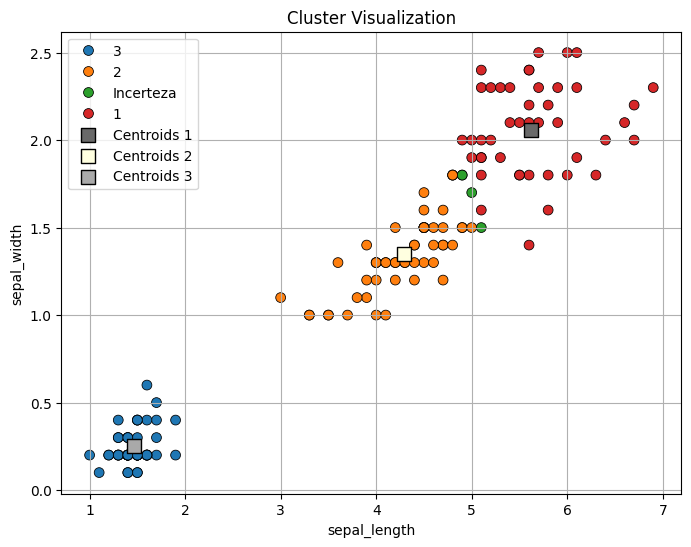

In [17]:
cores = list(mcolors.CSS4_COLORS.keys())
random.shuffle(cores)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='petal_length', y='petal_width', hue='species', s=50, edgecolors='k', palette='tab10', legend='full')
for i in range(len(centroids)):
    plt.scatter(centroids['location'][i][0], centroids['location'][i][1], c=cores[i], marker='s', s=100, edgecolors='k', label=f'Centroids {i+1}')


plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.grid(True)
plt.title('Cluster Visualization')
plt.legend()
plt.show()

In [18]:
df = sns.load_dataset('iris')
df = df[df['species'].isin(['versicolor', 'virginica'])]
df = df.drop(columns=['sepal_length','sepal_width','species'], axis=1)
CLUSTERS = 2
membership_table = random_membership_table(df,CLUSTERS)
centroids,membership = centroids_stop_method(membership_table,df)
incertos, categorias = gera_clusters_final(membership, 0.55, membership_table)
df['species'] = categorias
membership.index = membership.index + 1
membership[[coluna for coluna in membership.columns if coluna in incertos]]

,Variable 74,Variable 78,Variable 84
1,0.497582,0.497582,0.453582
2,0.502418,0.502418,0.546418


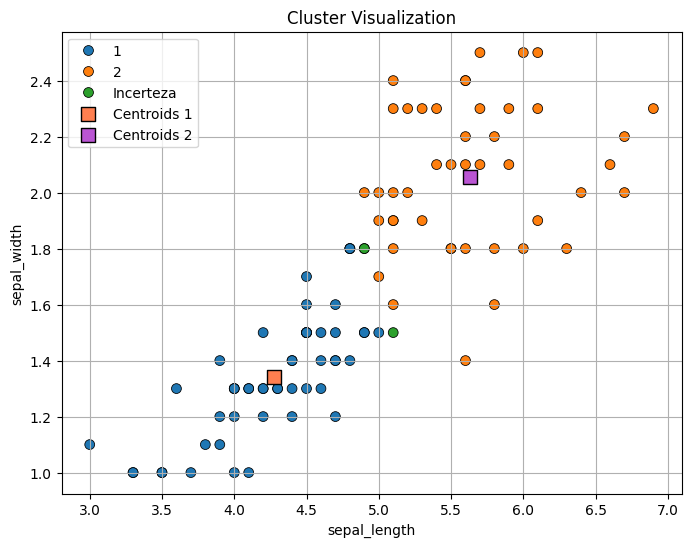

In [19]:
cores = list(mcolors.CSS4_COLORS.keys())
random.shuffle(cores)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='petal_length', y='petal_width', hue='species', s=50, edgecolors='k', palette='tab10', legend='full')
for i in range(len(centroids)):
    plt.scatter(centroids['location'][i][0], centroids['location'][i][1], c=cores[i], marker='s', s=100, edgecolors='k', label=f'Centroids {i+1}')


plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.grid(True)
plt.title('Cluster Visualization')
plt.legend()
plt.show()

In [20]:
df = sns.load_dataset('iris')
df = df[df['species'].isin(['versicolor', 'virginica'])]
df = df.drop(columns=['petal_length','petal_width','species'], axis=1)

CLUSTERS = 2
membership_table = random_membership_table(df,CLUSTERS)
centroids,membership = centroids_stop_method(membership_table,df)
incertos, categorias = gera_clusters_final(membership, 0.55, membership_table)
df['species'] = categorias
membership.index = membership.index + 1
membership[[coluna for coluna in membership.columns if coluna in incertos]]

,Variable 54,Variable 84
1,0.548797,0.490467
2,0.451203,0.509533


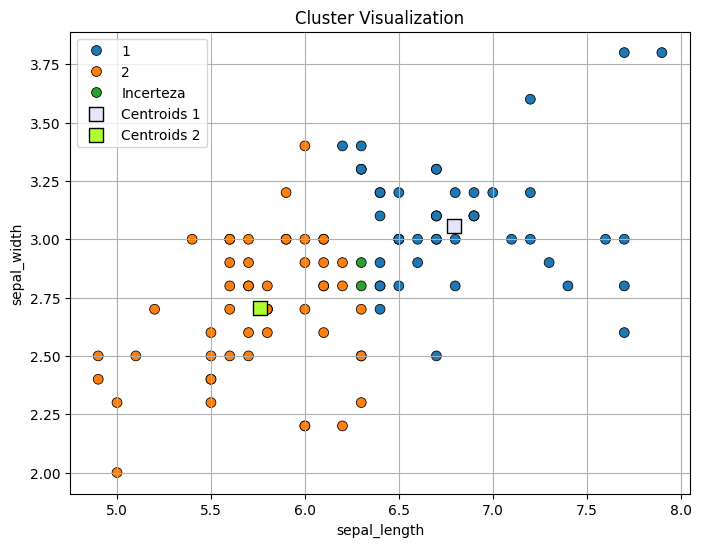

In [21]:
cores = list(mcolors.CSS4_COLORS.keys())
random.shuffle(cores)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='sepal_length', y='sepal_width', hue='species', s=50, edgecolors='k', palette='tab10', legend='full')
for i in range(len(centroids)):
    plt.scatter(centroids['location'][i][0], centroids['location'][i][1], c=cores[i], marker='s', s=100, edgecolors='k', label=f'Centroids {i+1}')


plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.grid(True)
plt.title('Cluster Visualization')
plt.legend()
plt.show()